#Phase-1 Data analysis & preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tabulate import tabulate
 # Updated import for TensorFlow
%matplotlib inline

In [2]:
#Loading Data Set
note_df = pd.read_csv("/banknote-authentication.csv")

In [21]:
#Exlopring Dataset
print("Number of Rows in a dataset: %s" % note_df.shape[0])
print("Number of Features in a dataset: %s" % note_df.shape[1])

Number of Rows in a dataset: 1372
Number of Features in a dataset: 5


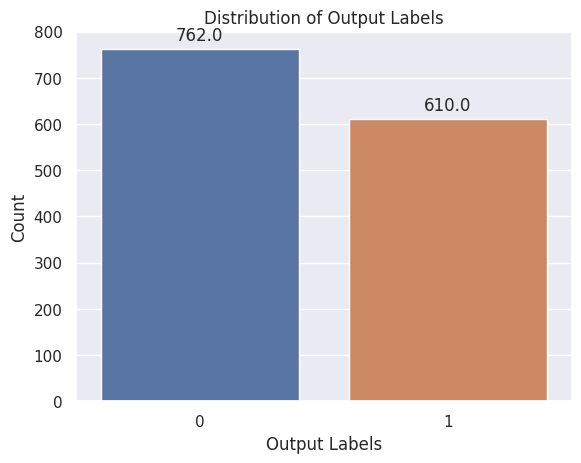

In [22]:
#Distribution of output labels
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
ax = sns.countplot(x='class', data=note_df)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Distribution of Output Labels')
plt.xlabel('Output Labels')
plt.ylabel('Count')
plt.show()



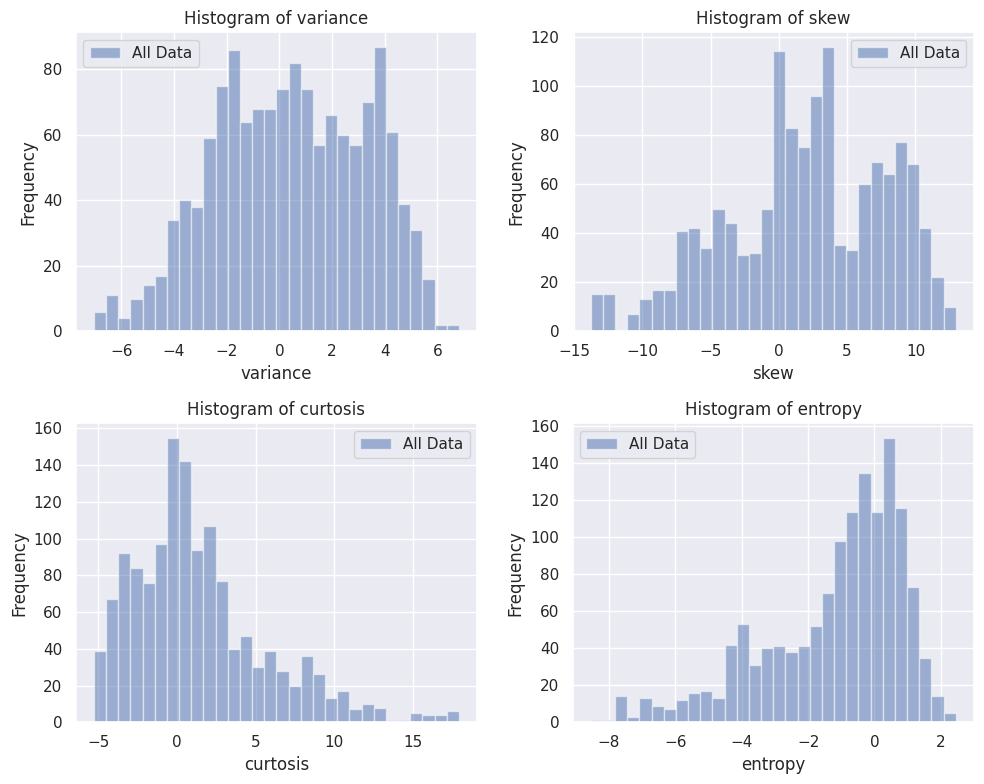

In [5]:
import matplotlib.pyplot as plt

features = note_df.columns[:-1]

# Creates subplots in a 2x2 format
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flattens the axes array for easy indexing
axes = axes.flatten()

for i, feature in enumerate(features):
    axes[i].hist(note_df[feature], bins=30, alpha=0.5, label='All Data')
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
note_df.head()

,variance,skew,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


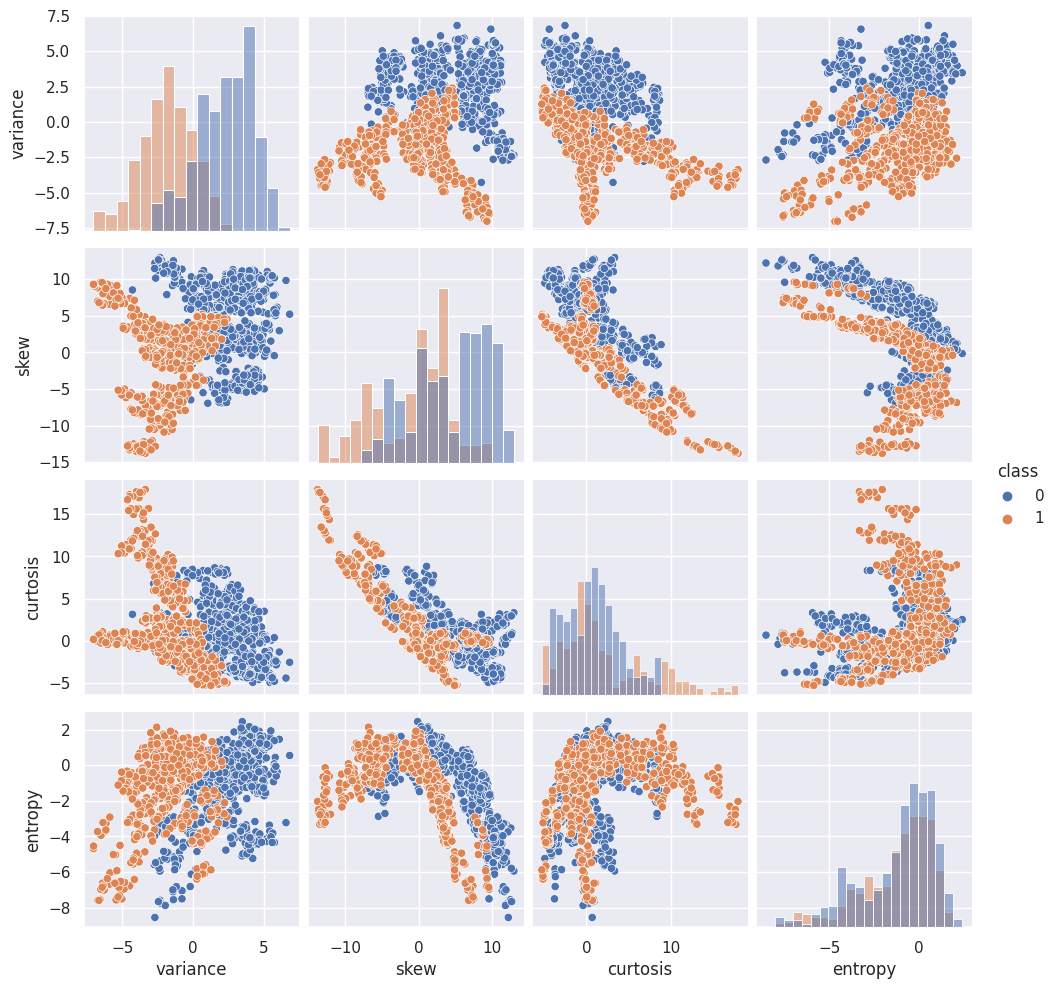

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(note_df, hue='class', diag_kind='hist')
plt.show()

In [6]:
feature_statistics = note_df.describe().loc[['min', 'max', 'mean', 'std']]
feature_statistics = feature_statistics.transpose()
print(feature_statistics)


              min      max      mean       std
variance  -7.0421   6.8248  0.433735  2.842763
skew     -13.7731  12.9516  1.922353  5.869047
curtosis  -5.2861  17.9274  1.397627  4.310030
entropy   -8.5482   2.4495 -1.191657  2.101013
class      0.0000   1.0000  0.444606  0.497103


#Phase 2: Building a model to overfit the entire dataset

In [20]:
data = note_df.values

# Extract features (X) and labels (y)
X = data[:, :-1].astype(np.float32)
y = data[:, -1].astype(np.int32)

# Min-Max Normalization
min_vals = np.min(X, axis=0)
max_vals = np.max(X, axis=0)
X_minmax_normalized = (X - min_vals) / (max_vals - min_vals)

# Z-score Normalization
mean_vals = np.mean(X, axis=0)
std_devs = np.std(X, axis=0)
X_zscore_normalized = (X - mean_vals) / std_devs

# CreatingDataFrames for better visualization
minmax_normalized_df = pd.DataFrame(X_minmax_normalized, columns=note_df.columns[:-1])
zscore_normalized_df = pd.DataFrame(X_zscore_normalized, columns=note_df.columns[:-1])

# Displays the normalized DataFrames
print("Min-Max Normalized Data:")
print(tabulate(minmax_normalized_df.head(), headers='keys', tablefmt='fancy_grid'))

print("\nZ-score Normalized Data:")
print(tabulate(zscore_normalized_df.head(), headers='keys', tablefmt='fancy_grid'))
# Splits the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Defining  subclassed model for the neural network
class NeuralNetworkModel(tf.keras.Model):
    def __init__(self, input_size):
        super(NeuralNetworkModel, self).__init__()
        self.hidden_layer1 = tf.keras.layers.Dense(64, activation='relu')
        self.hidden_layer2 = tf.keras.layers.Dense(32, activation='relu')
        self.hidden_layer3 = tf.keras.layers.Dense(16, activation='relu')
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')


    def call(self, inputs):
        x = self.hidden_layer1(inputs)
        x = self.hidden_layer2(x)
        x = self.hidden_layer3(x)
        return self.output_layer(x)

# Instantiating the model
nn_model = NeuralNetworkModel(input_size=X.shape[1])

# Defining the loss function (binary cross-entropy)
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Defining the optimizer (e.g., Gradient Descent)
learning_rate = 0.01
optimizer = tf.optimizers.SGD(learning_rate)

# Training the model with early stopping
epochs = 2000
best_loss = float('inf')
patience = 100

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        predictions = nn_model(X_train)
        current_loss = loss_fn(y_train.reshape(-1, 1), predictions)

    grads = tape.gradient(current_loss, nn_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, nn_model.trainable_variables))

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {current_loss.numpy()}')
        # Calculate training accuracy
        train_predictions = nn_model(X_train).numpy()
        train_predictions = np.round(train_predictions)
        train_accuracy = np.mean(train_predictions == y_train.reshape(-1, 1))
        print(f'Epoch {epoch}, Loss: {current_loss.numpy()}, Training Accuracy: {train_accuracy * 100:.2f}%')

    # Check if the validation loss has improved; if not, break the loop
    val_predictions = nn_model(X_val).numpy()
    val_loss = loss_fn(y_val.reshape(-1, 1), val_predictions).numpy()

    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print(f'Early stopping at epoch {epoch} as there is no improvement in validation loss.')
        break

# After training, evaluates the final model on the validation set
val_predictions = nn_model(X_val).numpy()
val_predictions = np.round(val_predictions)
val_accuracy = np.mean(val_predictions == y_val.reshape(-1, 1))
print(f'Final Validation Accuracy: {val_accuracy * 100:.2f}%')

#Evaluates the model on the test set
test_predictions = nn_model(X_test).numpy()
test_predictions = np.round(test_predictions)
test_accuracy = np.mean(test_predictions == y_test.reshape(-1, 1))
print(f'Final Test Accuracy: {test_accuracy * 100:.2f}%')

Min-Max Normalized Data:
╒════╤════════════╤══════════╤════════════╤═══════════╕
│    │   variance │     skew │   curtosis │   entropy │
╞════╪════════════╪══════════╪════════════╪═══════════╡
│  0 │   0.769004 │ 0.839643 │  0.106783  │  0.736628 │
├────┼────────────┼──────────┼────────────┼───────────┤
│  1 │   0.835659 │ 0.820982 │  0.121804  │  0.644326 │
├────┼────────────┼──────────┼────────────┼───────────┤
│  2 │   0.786629 │ 0.416648 │  0.310608  │  0.786951 │
├────┼────────────┼──────────┼────────────┼───────────┤
│  3 │   0.757105 │ 0.871699 │  0.0549206 │  0.45044  │
├────┼────────────┼──────────┼────────────┼───────────┤
│  4 │   0.531578 │ 0.348662 │  0.424662  │  0.687362 │
╘════╧════════════╧══════════╧════════════╧═══════════╛

Z-score Normalized Data:
╒════╤════════════╤═══════════╤════════════╤════════════╕
│    │   variance │      skew │   curtosis │    entropy │
╞════╪════════════╪═══════════╪════════════╪════════════╡
│  0 │  1.12181   │  1.14945  │  -0.97597  │  0

In [10]:
#Creating our own generalized model
class GeneralizedModel(tf.keras.Model):
    def __init__(self, input_size):
        super(GeneralizedModel, self).__init__()
        self.hidden_layer1 = tf.keras.layers.Dense(32, activation='relu')
        self.hidden_layer2 = tf.keras.layers.Dense(16, activation='relu')
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.hidden_layer1(inputs)
        x = self.hidden_layer2(x)
        return self.output_layer(x)

    def get_feature_importance(self, X):
        # Assuming a simple calculation based on weights (you may need to adjust this)
        feature_importance = np.abs(self.layers[0].get_weights()[0].flatten())
        return feature_importance / np.sum(feature_importance)


# Instantiating the generalized model
gen_model = GeneralizedModel(input_size=X.shape[1])


In [11]:
# Spliting the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [12]:
# Defining the optimizer (e.g., Gradient Descent)
learning_rate = 0.01
optimizer = tf.optimizers.SGD(learning_rate)

# Training the model with early stopping
epochs = 2000
best_loss = float('inf')
patience = 100

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        predictions = gen_model(X_train)
        current_loss = loss_fn(y_train.reshape(-1, 1), predictions)

    grads = tape.gradient(current_loss, gen_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, gen_model.trainable_variables))

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {current_loss.numpy()}')
        # Calculates training accuracy
        train_predictions = gen_model(X_train).numpy()
        train_predictions = np.round(train_predictions)
        train_accuracy = np.mean(train_predictions == y_train.reshape(-1, 1))
        print(f'Epoch {epoch}, Loss: {current_loss.numpy()}, Training Accuracy: {train_accuracy * 100:.2f}%')

    # Checks if the validation loss has improved; if not, break the loop
    val_predictions = gen_model(X_val).numpy()
    val_loss = loss_fn(y_val.reshape(-1, 1), val_predictions).numpy()

    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print(f'Early stopping at epoch {epoch} as there is no improvement in validation loss.')
        break
         #After training, evaluates the final model on the validation set
val_predictions = gen_model(X_val).numpy()
val_predictions = np.round(val_predictions)
val_accuracy = np.mean(val_predictions == y_val.reshape(-1, 1))
print(f'Final Validation Accuracy: {val_accuracy * 100:.2f}%')


Epoch 0, Loss: 1.364875078201294
Epoch 0, Loss: 1.364875078201294, Training Accuracy: 39.47%
Epoch 50, Loss: 0.44968873262405396
Epoch 50, Loss: 0.44968873262405396, Training Accuracy: 76.39%
Epoch 100, Loss: 0.304935485124588
Epoch 100, Loss: 0.304935485124588, Training Accuracy: 91.52%
Epoch 150, Loss: 0.22309502959251404
Epoch 150, Loss: 0.22309502959251404, Training Accuracy: 97.08%
Epoch 200, Loss: 0.17019934952259064
Epoch 200, Loss: 0.17019934952259064, Training Accuracy: 98.27%
Epoch 250, Loss: 0.13437944650650024
Epoch 250, Loss: 0.13437944650650024, Training Accuracy: 98.27%
Epoch 300, Loss: 0.1103862076997757
Epoch 300, Loss: 0.1103862076997757, Training Accuracy: 98.81%
Epoch 350, Loss: 0.093694306910038
Epoch 350, Loss: 0.093694306910038, Training Accuracy: 99.00%
Epoch 400, Loss: 0.08144194632768631
Epoch 400, Loss: 0.08144194632768631, Training Accuracy: 99.36%
Epoch 450, Loss: 0.07206527888774872
Epoch 450, Loss: 0.07206527888774872, Training Accuracy: 99.45%
Epoch 500,

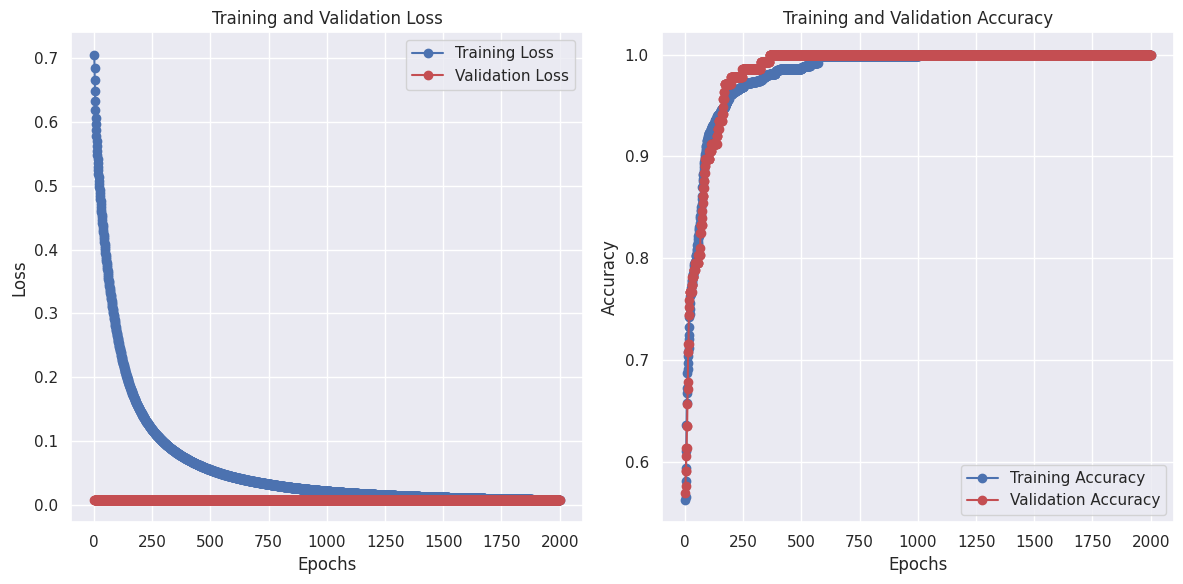

In [62]:
# plots the learning curve
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_history) + 1)

# Plotting loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_history, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy_history, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [63]:


# After training, evaluates the model on the validation set
val_predictions = gen_model(X_val).numpy()
val_predictions = np.round(val_predictions)
val_accuracy = np.mean(val_predictions == y_val.reshape(-1, 1))
print(f'Final Validation Accuracy: {val_accuracy * 100:.2f}%')

# Evaluates the model on the test set
test_predictions = gen_model(X_test).numpy()
test_predictions = np.round(test_predictions)
test_accuracy = np.mean(test_predictions == y_test.reshape(-1, 1))
print(f'Final Test Accuracy: {test_accuracy * 100:.2f}%')

Final Validation Accuracy: 100.00%
Final Test Accuracy: 100.00%


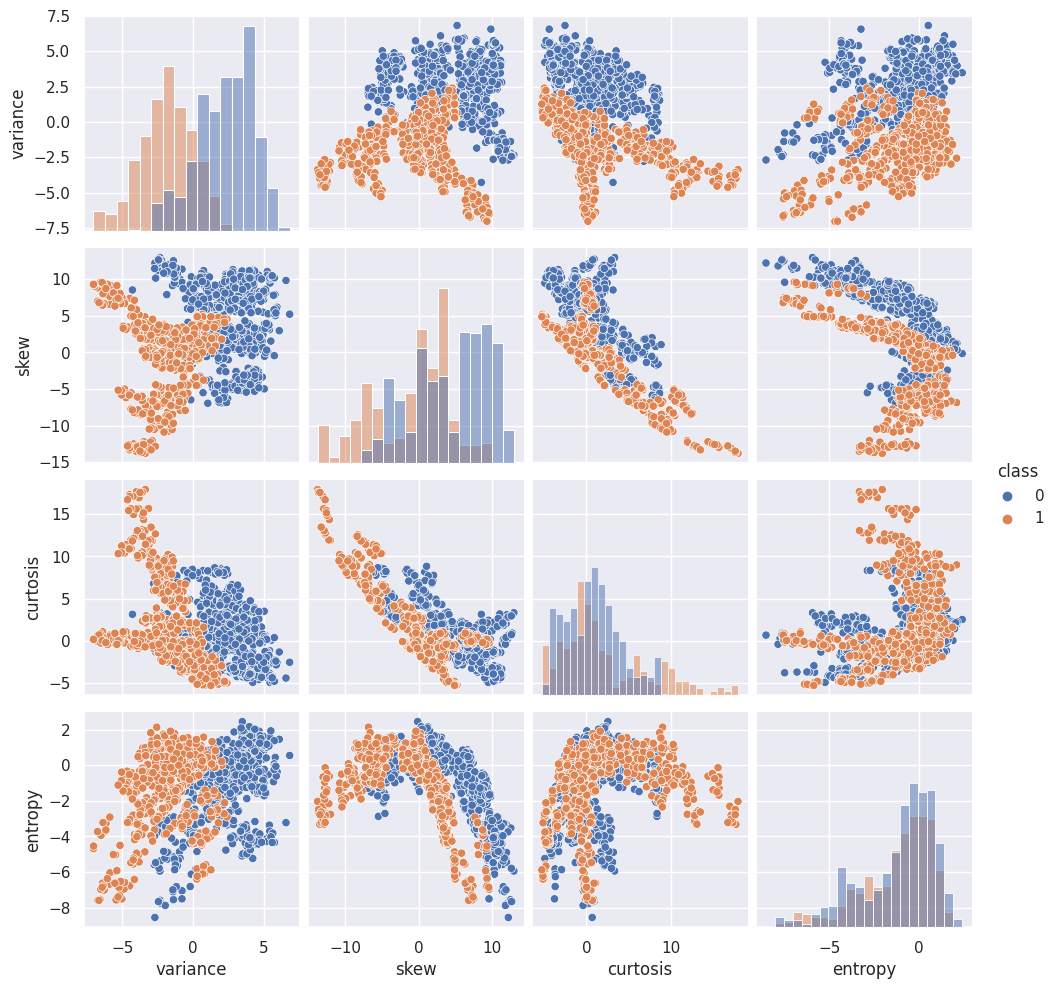

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(note_df, hue='class', diag_kind='hist')
plt.show()

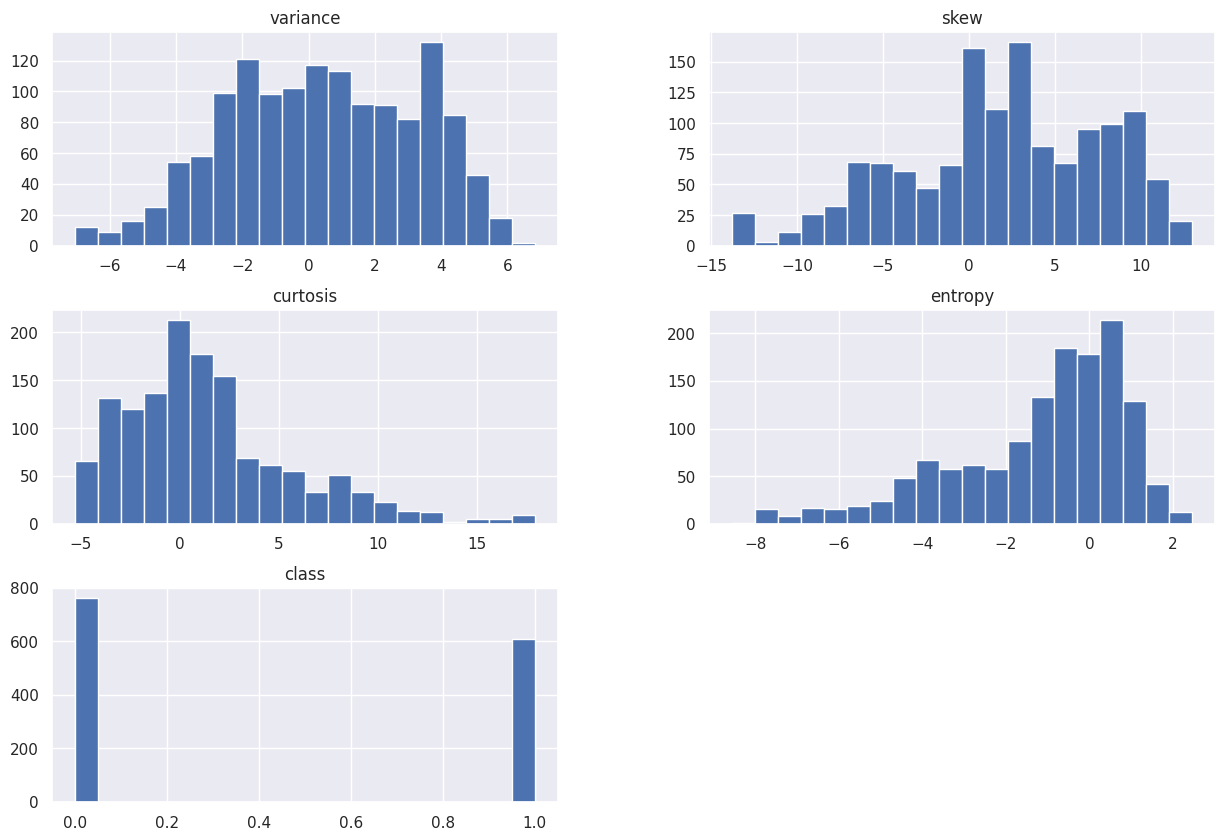

In [ ]:
import matplotlib.pyplot as plt

note_df.hist(bins=20, figsize=(15, 10))
plt.show()


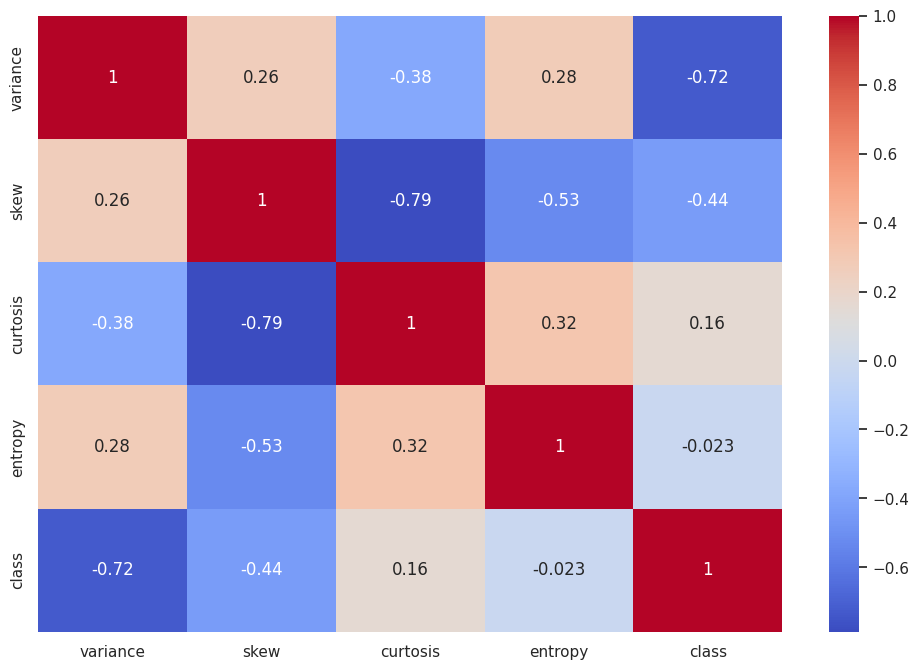

In [ ]:
import seaborn as sns

#Correlation Matrix Heat Map
corr_matrix = note_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [64]:
import pandas as pd

feature_statistics = note_df[['variance', 'skew', 'curtosis', 'entropy']].describe()

# Displays the statistics
print("Feature Statistics:")
print(feature_statistics)

# Individual feature statistics
mean_variance = note_df['variance'].mean()
std_dev_skew = note_df['skew'].std()
min_curtosis = note_df['curtosis'].min()
max_entropy = note_df['entropy'].max()

print(f"\nIndividual Feature Statistics:")
print(f"Mean Variance: {mean_variance}")
print(f"Standard Deviation Skew: {std_dev_skew}")
print(f"Minimum Curtosis: {min_curtosis}")
print(f"Maximum Entropy: {max_entropy}")


Feature Statistics:
          variance         skew     curtosis      entropy
count  1372.000000  1372.000000  1372.000000  1372.000000
mean      0.433735     1.922353     1.397627    -1.191657
std       2.842763     5.869047     4.310030     2.101013
min      -7.042100   -13.773100    -5.286100    -8.548200
25%      -1.773000    -1.708200    -1.574975    -2.413450
50%       0.496180     2.319650     0.616630    -0.586650
75%       2.821475     6.814625     3.179250     0.394810
max       6.824800    12.951600    17.927400     2.449500

Individual Feature Statistics:
Mean Variance: 0.4337352570699707
Standard Deviation Skew: 5.869046743694848
Minimum Curtosis: -5.2861
Maximum Entropy: 2.4495


In [13]:
correlation_matrix = note_df.corr()

# Extracts the correlation of each feature with the target variable
correlation_with_target = correlation_matrix['class'].drop('class')  # Drop the target variable itself

# Displays the correlation values
print("Correlation with Target:")
print(correlation_with_target)


Correlation with Target:
variance   -0.724843
skew       -0.444688
curtosis    0.155883
entropy    -0.023424
Name: class, dtype: float64


5/5 [==============================] - 0s 4ms/step


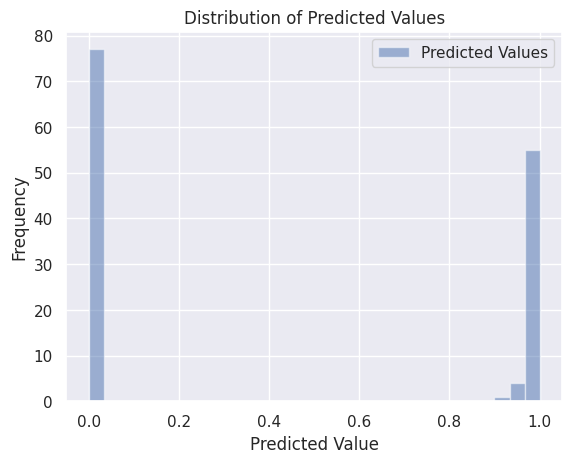

Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# nn_model as our neural network model
val_predictions = nn_model.predict(X_val)

# Flattens the predictions
val_predictions_flat = val_predictions.flatten()

# Plots the distribution of predicted values
plt.hist(val_predictions_flat, bins=30, alpha=0.5, label='Predicted Values')
plt.title('Distribution of Predicted Values')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Adjusting the threshold and calculate metrics
threshold = 0.32
adjusted_predictions = (val_predictions_flat > threshold).astype(int)

# Calculate evaluation metrics with the adjusted predictions
accuracy = accuracy_score(y_val, adjusted_predictions)
precision = precision_score(y_val, adjusted_predictions, zero_division=1.0)  # Sets zero_division parameter
recall = recall_score(y_val, adjusted_predictions)
f1 = f1_score(y_val, adjusted_predictions)

# Display the adjusted metrics
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')


In [15]:
# Assuming X_val, y_val are your validation set
# Extract the second row for prediction
sample_row = X_val[1:2, :]

# Make predictions on the sample row
prediction = gen_model.predict(sample_row)
predicted_class = int(prediction > 0.5)

# Display the actual class and the predicted class
actual_class = int(y_val[1])
print(f"Actual Class: {actual_class}, Predicted Class: {predicted_class}")


1/1 [==============================] - 0s 158ms/step
Actual Class: 1, Predicted Class: 1


In [16]:
note_df.head()

,variance,skew,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


#Phase 3: Model Selection

In [17]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#Data is stored in 'X' (features) and 'y' (labels)

# Step 1: Shuffle the data
seed = 42  # Use any seed for reproducibility
np.random.seed(seed)

shuffled_indices = np.random.permutation(len(X))
X_shuffled = X[shuffled_indices]
y_shuffled = y[shuffled_indices]

# Step 2: Splits the data into training and validation sets
train_size = 0.8  # could be adjusted
X_train, X_val, y_train, y_val = train_test_split(X_shuffled, y_shuffled, train_size=train_size, random_state=seed)

# Step 3: Build a Logistic Regression model
logistic_model = LogisticRegression(random_state=seed)

# Step 4: Train the model
logistic_model.fit(X_train, y_train)

# Step 5: Evaluate the model on the validation set
y_val_pred = logistic_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Display the results
print(f'Accuracy on Validation Set (Logistic Regression): {val_accuracy * 100:.2f}%')


Accuracy on Validation Set (Logistic Regression): 98.91%


Model Architecture: [64, 32, 16, 8]
Accuracy on Training Set: 100.00%
Accuracy on Validation Set: 100.00%
----------------------------------------
Model Architecture: [32, 16, 8]
Accuracy on Training Set: 100.00%
Accuracy on Validation Set: 100.00%
----------------------------------------


Model Architecture: [16, 8]
Accuracy on Training Set: 100.00%
Accuracy on Validation Set: 100.00%
----------------------------------------


Model Architecture: [8, 1]
Accuracy on Training Set: 55.97%
Accuracy on Validation Set: 53.82%
----------------------------------------


Model Architecture: [4, 1]
Accuracy on Training Set: 99.91%
Accuracy on Validation Set: 99.64%
----------------------------------------


Model Architecture: [2, 1]
Accuracy on Training Set: 100.00%
Accuracy on Validation Set: 100.00%
----------------------------------------


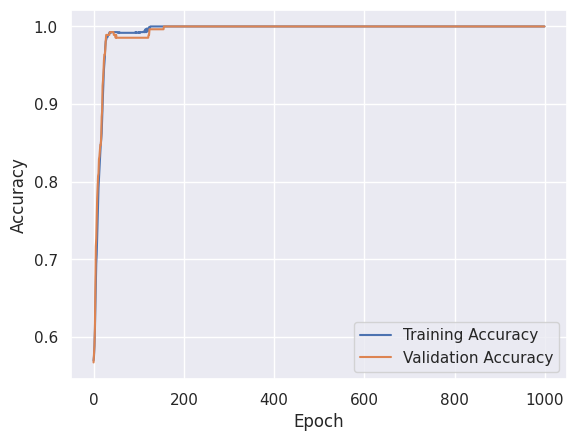

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

# Function to create and train a neural network model
def create_and_train_nn_model(architecture, X_train, y_train, X_val, y_val, epochs=1000):
    model = Sequential()

    # Build the neural network with the specified architecture
    for neurons in architecture:
        model.add(Dense(neurons, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # ModelCheckpoint to save the best model in the native Keras format
    checkpoint = ModelCheckpoint('best_model', save_best_only=True)

    # Trains the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[checkpoint], verbose=0)

    # Loads the best model
    model.load_weights('best_model')

    return model, history

# Data loaded and preprocessed (X, y)
# Splits the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Defines the neural network architectures to test
architectures = [
    [64, 32, 16, 8],
    [32, 16, 8],
    [16, 8],
    [8, 1],
    [4, 1],
    [2, 1]
]

# Train and evaluate models for each architecture
for architecture in architectures:
    model, history = create_and_train_nn_model(architecture, X_train, y_train, X_val, y_val)

    # Evaluate the model on the training set
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

    print(f'Model Architecture: {architecture}')
    print(f'Accuracy on Training Set: {train_accuracy * 100:.2f}%')
    print(f'Accuracy on Validation Set: {val_accuracy * 100:.2f}%')
    print('----------------------------------------')

# Plots the learning curves for the best model
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Phase 4: Feature importance and reduction

In [85]:

note_df_variance = note_df.iloc[:, [0, -1]]
note_df_variance.head()
#Phase 4
data = note_df_variance.values

# Extract features (X) and labels (y)
X_variance = data[:].astype(np.float32)
y_variance = data[:].astype(np.int32)


# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_variance, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Instantiate the generalized model
gen_model = GeneralizedModel(input_size=1)
# Define the optimizer (e.g., Gradient Descent)
learning_rate = 0.01
optimizer = tf.optimizers.SGD(learning_rate)

# Train the model with early stopping
epochs = 2000
best_loss = float('inf')
patience = 100

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        predictions = gen_model(X_train)
        current_loss = loss_fn(y_train.reshape(-1, 1), predictions)

    grads = tape.gradient(current_loss, gen_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, gen_model.trainable_variables))

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {current_loss.numpy()}')
        # Calculate training accuracy
        train_predictions = gen_model(X_train).numpy()
        train_predictions = np.round(train_predictions)
        train_accuracy = np.mean(train_predictions == y_train.reshape(-1, 1))
        print(f'Epoch {epoch}, Loss: {current_loss.numpy()}, Training Accuracy: {train_accuracy * 100:.2f}%')

    # Check if the validation loss has improved; if not, break the loop
    val_predictions = gen_model(X_val).numpy()
    val_loss = loss_fn(y_val.reshape(-1, 1), val_predictions).numpy()

    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print(f'Early stopping at epoch {epoch} as there is no improvement in validation loss.')
        break
         #After training, evaluate the final model on the validation set
val_predictions = gen_model(X_val).numpy()
val_predictions = np.round(val_predictions)
val_accuracy = np.mean(val_predictions == y_val.reshape(-1, 1))
print(f'Final Validation Accuracy: {val_accuracy * 100:.2f}%')


Epoch 0, Loss: 0.8367919921875
Epoch 0, Loss: 0.8367919921875, Training Accuracy: 44.21%
Epoch 50, Loss: 0.4837835729122162
Epoch 50, Loss: 0.4837835729122162, Training Accuracy: 89.15%
Epoch 100, Loss: 0.3706846833229065
Epoch 100, Loss: 0.3706846833229065, Training Accuracy: 88.51%
Epoch 150, Loss: 0.3152598738670349
Epoch 150, Loss: 0.3152598738670349, Training Accuracy: 88.51%
Epoch 200, Loss: 0.28414133191108704
Epoch 200, Loss: 0.28414133191108704, Training Accuracy: 88.88%
Epoch 250, Loss: 0.26346585154533386
Epoch 250, Loss: 0.26346585154533386, Training Accuracy: 89.06%
Epoch 300, Loss: 0.24734173715114594
Epoch 300, Loss: 0.24734173715114594, Training Accuracy: 89.33%
Epoch 350, Loss: 0.23322288691997528
Epoch 350, Loss: 0.23322288691997528, Training Accuracy: 89.61%
Epoch 400, Loss: 0.21990860998630524
Epoch 400, Loss: 0.21990860998630524, Training Accuracy: 90.15%
Epoch 450, Loss: 0.20683202147483826
Epoch 450, Loss: 0.20683202147483826, Training Accuracy: 90.88%
Epoch 500,

Feature Statistics:
          variance        class
count  1372.000000  1372.000000
mean      0.433735     0.444606
std       2.842763     0.497103
min      -7.042100     0.000000
25%      -1.773000     0.000000
50%       0.496180     0.000000
75%       2.821475     1.000000
max       6.824800     1.000000


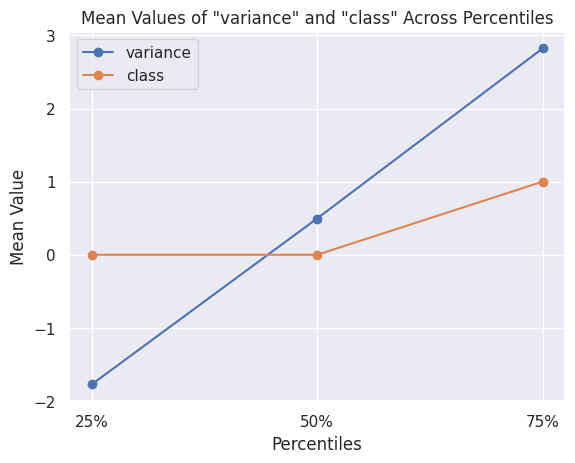

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_statistics = note_df_variance.describe()

# Displays the statistics
print("Feature Statistics:")
print(feature_statistics)

import matplotlib.pyplot as plt

# Extract relevant statistics
percentiles = ['25%', '50%', '75%']
mean_values = note_df_variance.describe().loc[['25%', '50%', '75%'], ['variance', 'class']]

# Create a line graph
plt.plot(percentiles, mean_values['variance'], marker='o', label='variance')
plt.plot(percentiles, mean_values['class'], marker='o', label='class')

# Add labels and title
plt.xlabel('Percentiles')
plt.ylabel('Mean Value')
plt.title('Mean Values of "variance" and "class" Across Percentiles')
plt.legend()
plt.show()


In [101]:
note_df_skew = note_df.iloc[:, [1, -1]]
note_df_skew.head()
#Phase 4
# Assuming note_df is your DataFrame containing the data
data = note_df_skew.values

# Extract features (X) and labels (y)
X_skew = data[:].astype(np.float32)
y_skew = data[:].astype(np.int32)


# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_skew, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Instantiate the generalized model
gen_model = GeneralizedModel(input_size=1)
# Define the optimizer (e.g., Gradient Descent)
learning_rate = 0.01
optimizer = tf.optimizers.SGD(learning_rate)

# Train the model with early stopping
epochs = 2000
best_loss = float('inf')
patience = 100

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        predictions = gen_model(X_train)
        current_loss = loss_fn(y_train.reshape(-1, 1), predictions)

    grads = tape.gradient(current_loss, gen_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, gen_model.trainable_variables))

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {current_loss.numpy()}')
        # Calculate training accuracy
        train_predictions = gen_model(X_train).numpy()
        train_predictions = np.round(train_predictions)
        train_accuracy = np.mean(train_predictions == y_train.reshape(-1, 1))
        print(f'Epoch {epoch}, Loss: {current_loss.numpy()}, Training Accuracy: {train_accuracy * 100:.2f}%')

    # Check if the validation loss has improved; if not, break the loop
    val_predictions = gen_model(X_val).numpy()
    val_loss = loss_fn(y_val.reshape(-1, 1), val_predictions).numpy()

    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print(f'Early stopping at epoch {epoch} as there is no improvement in validation loss.')
        break
         #After training, evaluate the final model on the validation set
val_predictions = gen_model(X_val).numpy()
val_predictions = np.round(val_predictions)
val_accuracy = np.mean(val_predictions == y_val.reshape(-1, 1))
print(f'Final Validation Accuracy: {val_accuracy * 100:.2f}%')


Epoch 0, Loss: 0.6618385910987854
Epoch 0, Loss: 0.6618385910987854, Training Accuracy: 80.86%
Epoch 50, Loss: 0.5160380005836487
Epoch 50, Loss: 0.5160380005836487, Training Accuracy: 71.47%
Epoch 100, Loss: 0.4950200319290161
Epoch 100, Loss: 0.4950200319290161, Training Accuracy: 72.93%
Epoch 150, Loss: 0.47599244117736816
Epoch 150, Loss: 0.47599244117736816, Training Accuracy: 75.21%
Epoch 200, Loss: 0.45744287967681885
Epoch 200, Loss: 0.45744287967681885, Training Accuracy: 79.31%
Epoch 250, Loss: 0.4375632703304291
Epoch 250, Loss: 0.4375632703304291, Training Accuracy: 81.95%
Epoch 300, Loss: 0.4164606034755707
Epoch 300, Loss: 0.4164606034755707, Training Accuracy: 83.14%
Epoch 350, Loss: 0.3939674198627472
Epoch 350, Loss: 0.3939674198627472, Training Accuracy: 85.05%
Epoch 400, Loss: 0.3700252175331116
Epoch 400, Loss: 0.3700252175331116, Training Accuracy: 86.14%
Epoch 450, Loss: 0.34162282943725586
Epoch 450, Loss: 0.34162282943725586, Training Accuracy: 87.33%
Epoch 500,

Feature Statistics:
              skew        class
count  1372.000000  1372.000000
mean      1.922353     0.444606
std       5.869047     0.497103
min     -13.773100     0.000000
25%      -1.708200     0.000000
50%       2.319650     0.000000
75%       6.814625     1.000000
max      12.951600     1.000000


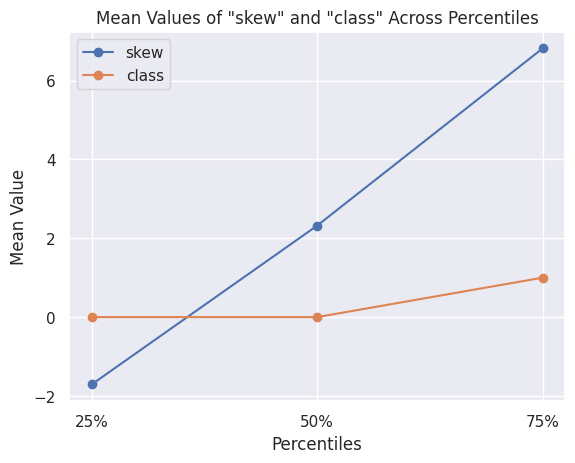

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_statistics = note_df_skew.describe()

# Displays the statistics
print("Feature Statistics:")
print(feature_statistics)

import matplotlib.pyplot as plt

# Extract relevant statistics
percentiles = ['25%', '50%', '75%']
mean_values = note_df_skew.describe().loc[['25%', '50%', '75%'], ['skew', 'class']]

# Create a line graph
plt.plot(percentiles, mean_values['skew'], marker='o', label='skew')
plt.plot(percentiles, mean_values['class'], marker='o', label='class')

# Add labels and title
plt.xlabel('Percentiles')
plt.ylabel('Mean Value')
plt.title('Mean Values of "skew" and "class" Across Percentiles')
plt.legend()
plt.show()

In [104]:
note_df_cutosis = note_df.iloc[:, [2, -1]]
note_df_cutosis.head()
#Phase 4
# Assuming note_df is your DataFrame containing the data
data = note_df_cutosis.values

# Extract features (X) and labels (y)
X_cutosis = data[:].astype(np.float32)
y_cutosis = data[:].astype(np.int32)


# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_cutosis, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Instantiate the generalized model
gen_model = GeneralizedModel(input_size=1)
# Define the optimizer (e.g., Gradient Descent)
learning_rate = 0.01
optimizer = tf.optimizers.SGD(learning_rate)

# Train the model with early stopping
epochs = 2000
best_loss = float('inf')
patience = 100

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        predictions = gen_model(X_train)
        current_loss = loss_fn(y_train.reshape(-1, 1), predictions)

    grads = tape.gradient(current_loss, gen_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, gen_model.trainable_variables))

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {current_loss.numpy()}')
        # Calculate training accuracy
        train_predictions = gen_model(X_train).numpy()
        train_predictions = np.round(train_predictions)
        train_accuracy = np.mean(train_predictions == y_train.reshape(-1, 1))
        print(f'Epoch {epoch}, Loss: {current_loss.numpy()}, Training Accuracy: {train_accuracy * 100:.2f}%')

    # Check if the validation loss has improved; if not, break the loop
    val_predictions = gen_model(X_val).numpy()
    val_loss = loss_fn(y_val.reshape(-1, 1), val_predictions).numpy()

    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print(f'Early stopping at epoch {epoch} as there is no improvement in validation loss.')
        break
         #After training, evaluate the final model on the validation set
val_predictions = gen_model(X_val).numpy()
val_predictions = np.round(val_predictions)
val_accuracy = np.mean(val_predictions == y_val.reshape(-1, 1))
print(f'Final Validation Accuracy: {val_accuracy * 100:.2f}%')


Epoch 0, Loss: 0.7486862540245056
Epoch 0, Loss: 0.7486862540245056, Training Accuracy: 45.21%
Epoch 50, Loss: 0.6498069763183594
Epoch 50, Loss: 0.6498069763183594, Training Accuracy: 83.77%
Epoch 100, Loss: 0.6215683221817017
Epoch 100, Loss: 0.6215683221817017, Training Accuracy: 89.15%
Epoch 150, Loss: 0.592287003993988
Epoch 150, Loss: 0.592287003993988, Training Accuracy: 93.80%
Epoch 200, Loss: 0.5586332082748413
Epoch 200, Loss: 0.5586332082748413, Training Accuracy: 95.99%
Epoch 250, Loss: 0.5208263397216797
Epoch 250, Loss: 0.5208263397216797, Training Accuracy: 98.63%
Epoch 300, Loss: 0.4692554175853729
Epoch 300, Loss: 0.4692554175853729, Training Accuracy: 100.00%
Epoch 350, Loss: 0.4240773320198059
Epoch 350, Loss: 0.4240773320198059, Training Accuracy: 100.00%
Epoch 400, Loss: 0.37817516922950745
Epoch 400, Loss: 0.37817516922950745, Training Accuracy: 100.00%
Epoch 450, Loss: 0.3332962989807129
Epoch 450, Loss: 0.3332962989807129, Training Accuracy: 100.00%
Epoch 500, L

Feature Statistics:
          curtosis        class
count  1372.000000  1372.000000
mean      1.397627     0.444606
std       4.310030     0.497103
min      -5.286100     0.000000
25%      -1.574975     0.000000
50%       0.616630     0.000000
75%       3.179250     1.000000
max      17.927400     1.000000


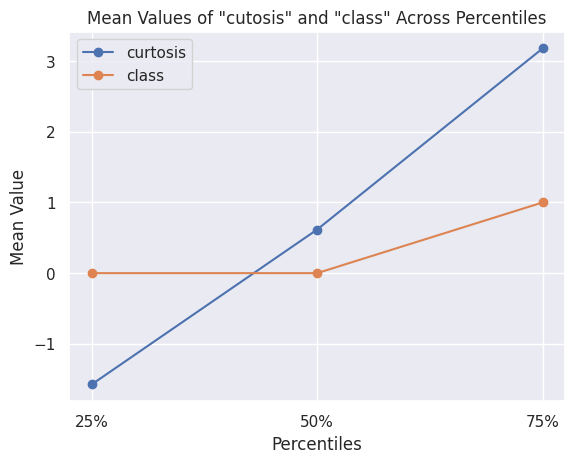

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_statistics = note_df_cutosis.describe()

# Displays the statistics
print("Feature Statistics:")
print(feature_statistics)

import matplotlib.pyplot as plt

# Extract relevant statistics
percentiles = ['25%', '50%', '75%']
mean_values = note_df_cutosis.describe().loc[['25%', '50%', '75%'], ['curtosis', 'class']]

# Create a line graph
plt.plot(percentiles, mean_values['curtosis'], marker='o', label='curtosis')
plt.plot(percentiles, mean_values['class'], marker='o', label='class')

# Add labels and title
plt.xlabel('Percentiles')
plt.ylabel('Mean Value')
plt.title('Mean Values of "cutosis" and "class" Across Percentiles')
plt.legend()
plt.show()

In [111]:
note_df_entropy = note_df.iloc[:, [3, -1]]
note_df_entropy.head()
#Phase 4
# Assuming note_df is your DataFrame containing the data
data = note_df_entropy.values

# Extract features (X) and labels (y)
X_entropy = data[:].astype(np.float32)
y_entropy = data[:].astype(np.int32)


# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_entropy, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Instantiate the generalized model
gen_model = GeneralizedModel(input_size=1)
# Define the optimizer (e.g., Gradient Descent)
learning_rate = 0.01
optimizer = tf.optimizers.SGD(learning_rate)

# Train the model with early stopping
epochs = 2000
best_loss = float('inf')
patience = 100

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        predictions = gen_model(X_train)
        current_loss = loss_fn(y_train.reshape(-1, 1), predictions)

    grads = tape.gradient(current_loss, gen_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, gen_model.trainable_variables))

    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {current_loss.numpy()}')
        # Calculate training accuracy
        train_predictions = gen_model(X_train).numpy()
        train_predictions = np.round(train_predictions)
        train_accuracy = np.mean(train_predictions == y_train.reshape(-1, 1))
        print(f'Epoch {epoch}, Loss: {current_loss.numpy()}, Training Accuracy: {train_accuracy * 100:.2f}%')

    # Check if the validation loss has improved; if not, break the loop
    val_predictions = gen_model(X_val).numpy()
    val_loss = loss_fn(y_val.reshape(-1, 1), val_predictions).numpy()

    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print(f'Early stopping at epoch {epoch} as there is no improvement in validation loss.')
        break
         #After training, evaluate the final model on the validation set
val_predictions = gen_model(X_val).numpy()
val_predictions = np.round(val_predictions)
val_accuracy = np.mean(val_predictions == y_val.reshape(-1, 1))
print(f'Final Validation Accuracy: {val_accuracy * 100:.2f}%')


Epoch 0, Loss: 0.7520010471343994
Epoch 0, Loss: 0.7520010471343994, Training Accuracy: 37.83%
Epoch 50, Loss: 0.7081692814826965
Epoch 50, Loss: 0.7081692814826965, Training Accuracy: 49.04%
Epoch 100, Loss: 0.6867940425872803
Epoch 100, Loss: 0.6867940425872803, Training Accuracy: 57.98%
Epoch 150, Loss: 0.6711883544921875
Epoch 150, Loss: 0.6711883544921875, Training Accuracy: 69.92%
Epoch 200, Loss: 0.6560590267181396
Epoch 200, Loss: 0.6560590267181396, Training Accuracy: 80.22%
Epoch 250, Loss: 0.6347317695617676
Epoch 250, Loss: 0.6347317695617676, Training Accuracy: 86.60%
Epoch 300, Loss: 0.6092526912689209
Epoch 300, Loss: 0.6092526912689209, Training Accuracy: 90.15%
Epoch 350, Loss: 0.5806586742401123
Epoch 350, Loss: 0.5806586742401123, Training Accuracy: 93.53%
Epoch 400, Loss: 0.5411763191223145
Epoch 400, Loss: 0.5411763191223145, Training Accuracy: 96.63%
Epoch 450, Loss: 0.49740713834762573
Epoch 450, Loss: 0.49740713834762573, Training Accuracy: 97.99%
Epoch 500, Los

Feature Statistics:
           entropy        class
count  1372.000000  1372.000000
mean     -1.191657     0.444606
std       2.101013     0.497103
min      -8.548200     0.000000
25%      -2.413450     0.000000
50%      -0.586650     0.000000
75%       0.394810     1.000000
max       2.449500     1.000000


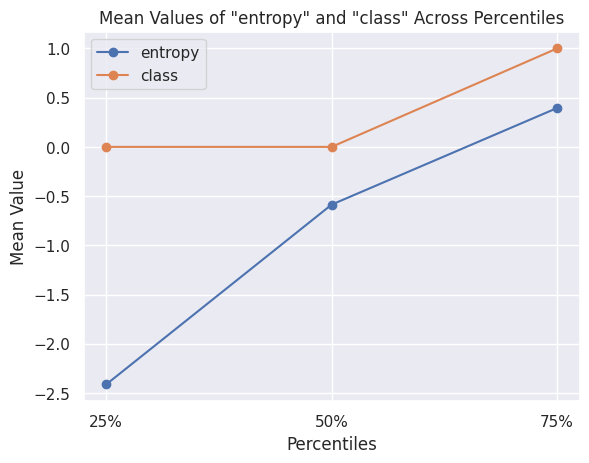

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_statistics = note_df_entropy.describe()

# Displays the statistics
print("Feature Statistics:")
print(feature_statistics)

import matplotlib.pyplot as plt

# Extract relevant statistics
percentiles = ['25%', '50%', '75%']
mean_values = note_df_entropy.describe().loc[['25%', '50%', '75%'], ['entropy', 'class']]

# Create a line graph
plt.plot(percentiles, mean_values['entropy'], marker='o', label='entropy')
plt.plot(percentiles, mean_values['class'], marker='o', label='class')

# Add labels and title
plt.xlabel('Percentiles')
plt.ylabel('Mean Value')
plt.title('Mean Values of "entropy" and "class" Across Percentiles')
plt.legend()
plt.show()

In [113]:
import numpy as np

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Initialize weights and bias
weights = np.zeros(X_train.shape[1])
bias = 0

# Hyperparameters
learning_rate = 0.01
epochs = 1000

# Training the model using gradient descent
for epoch in range(epochs):
    # Calculate predictions
    predictions = sigmoid(np.dot(X_train, weights) + bias)

    # Calculate gradients
    dw = (1 / len(y_train)) * np.dot(X_train.T, (predictions - y_train))
    db = (1 / len(y_train)) * np.sum(predictions - y_train)

    # Update weights and bias
    weights -= learning_rate * dw
    bias -= learning_rate * db

# Make predictions on training set
train_predictions_custom = np.round(sigmoid(np.dot(X_train, weights) + bias))

# Calculate training accuracy
train_accuracy_custom = np.mean(train_predictions_custom == y_train)
print(f'Training Accuracy (Custom Logistic Regression): {train_accuracy_custom * 100:.2f}%')

# Make predictions on validation set
val_predictions_custom = np.round(sigmoid(np.dot(X_val, weights) + bias))

# Calculate validation accuracy
val_accuracy_custom = np.mean(val_predictions_custom == y_val)
print(f'Validation Accuracy (Custom Logistic Regression): {val_accuracy_custom * 100:.2f}%')


Training Accuracy (Custom Logistic Regression): 100.00%
Validation Accuracy (Custom Logistic Regression): 100.00%
